# CS422 Project Report – Blind Data Classification  
**Fatima Vahora**

---

## Table of Contents
1. [Overview](#Overview)  
2. [Abstract](#Abstract)  
3. [Data Processing](#Data-Processing)  
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)  
5. [Data Visualization](#Data-Visualization)  
6. [Model Training and Selection](#Model-Training-and-Selection)  
7. [Conclusion](#Conclusion)  
8. [References](#References)  

---

## Overview

**Problem Statement:**  
This project focuses on building an accurate classification model using a "blind" dataset—meaning no prior metadata or domain knowledge is available for the features. Key challenges include handling severe class imbalance, high feature dimensionality, and redundant information within features.

**Relevant Literature:**  
The methodology was informed by studies on imbalanced learning, dimensionality reduction techniques like PCA, model evaluation metrics for multiclass problems, and model interoperability standards such as ONNX. See the Bibliography section for detailed references.

**Proposed Methodology:**  
- Perform thorough statistical analysis and data quality checks  
- Mitigate class imbalance through resampling techniques (undersampling with NearMiss) and class weighting  
- Apply Principal Component Analysis (PCA) to reduce dimensionality while preserving variance  
- Compare multiple classifiers including Logistic Regression, Decision Trees, Random Forests, and XGBoost  
- Optimize models using cross-validation and hyperparameter tuning  
- Export the best-performing model to ONNX format for easy deployment  

---

## Abstract

This project addresses classification on a dataset lacking feature context, complicating traditional feature engineering. The data exhibited significant class imbalance, causing bias in baseline models. To improve performance, undersampling techniques like NearMiss were employed to balance classes, coupled with feature scaling and PCA for dimensionality reduction. Multiple classification algorithms were evaluated, with Decision Tree (max depth=3) providing a good balance of interpretability and accuracy. The final pipeline was carefully constructed and validated with stratified splits and cross-validation to ensure robustness. Additionally, exporting the finalized model in ONNX format demonstrated readiness for deployment in diverse environments. Overall, the project highlights effective strategies for blind data classification in challenging conditions.


## Libraries Used

We used various libraries for this project, including:

- **Data handling & visualization:** `numpy`, `pandas`, `seaborn`, `matplotlib`  
- **Machine learning models:** `xgboost`, `sklearn` classifiers (e.g., Logistic Regression, Random Forest, SVM, KNN)  
- **Preprocessing & feature engineering:** `StandardScaler`, `MinMaxScaler`, `PCA`, `SelectKBest`, `ColumnTransformer`, `Pipeline`  
- **Imbalanced data handling:** `imblearn`’s `NearMiss`  
- **Model evaluation:** `sklearn.metrics` (accuracy, confusion matrix, classification report)  
- **Multicollinearity check:** `variance_inflation_factor` from `statsmodels`  
- **Model export & deployment:** `skl2onnx`, `onnxruntime`  
- **Miscellaneous:** `warnings` to suppress warnings  

These tools supported data processing, modeling, evaluation, and deployment.


In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Models and preprocessing imports
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import combinations
from sklearn import metrics
from imblearn.under_sampling import NearMiss


from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper

from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import onnxruntime as rt


### Data Processing & Exploratory Data Analysis (EDA)

Dataset shape: (1200000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB
First 5 rows of the dataset:


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420,-12.211,217.625,-15.612,140.047,76.905,131.592,198.161,82.873,127.350,224.593,-5.993,-14.690,143.072,153.440,2.000
1,-38.019,-14.196,9.584,22.294,-25.578,-18.374,-0.094,-33.712,-8.356,23.792,4.199,2.809,-59.331,-11.686,1.317,3.000
2,-39.197,-20.419,21.023,19.790,-25.903,-19.189,-2.954,-25.299,-6.612,26.285,5.911,6.192,-56.925,-4.675,-1.028,2.000
3,221.630,-5.785,216.725,-9.901,126.795,85.122,108.858,197.640,82.560,157.105,212.989,-3.621,-15.469,135.266,149.212,2.000
4,228.558,-12.448,204.637,-13.278,138.931,91.102,115.599,209.300,89.962,130.300,201.795,-1.574,-15.129,148.369,147.493,3.000


Last 5 rows of the dataset:


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
1199995,-24.786,-10.521,15.328,17.263,-27.448,-31.559,-2.868,-20.350,-8.639,28.821,1.947,1.784,-50.709,-8.420,-2.578,2.000
1199996,-39.555,-14.965,18.464,18.128,-26.634,-24.570,0.058,-22.118,-8.618,30.396,-8.075,0.906,-55.225,-0.794,-0.433,3.000
1199997,223.972,-17.368,213.833,-11.930,127.344,88.436,118.062,199.927,80.656,148.959,202.639,-1.998,-14.790,149.573,144.283,1.000
1199998,-58.147,-42.018,-42.593,-122.341,-10.620,-119.307,-57.133,-9.801,54.972,-88.306,34.893,-35.693,-59.268,33.830,54.899,2.000
1199999,249.063,-6.378,212.762,-15.056,124.103,85.608,122.830,196.327,85.209,117.895,214.756,-8.402,-25.281,130.081,141.078,3.000


No missing values detected in the dataset.
Number of duplicate rows in the dataset: 0
No constant columns detected.
Summary statistics for numeric columns:


,count,mean,std,min,25%,50%,75%,max
A,1200000.0,50.687,129.249,-73.089,-37.937,-31.978,228.002,268.774
B,1200000.0,-18.834,14.464,-83.224,-17.867,-13.699,-10.556,4.460
C,1200000.0,71.622,105.281,-59.729,7.553,13.488,212.344,256.170
D,1200000.0,-13.551,46.898,-137.582,-14.713,-8.004,19.558,32.638
E,1200000.0,29.442,72.823,-38.298,-24.363,-18.971,128.902,157.984
F,1200000.0,-6.185,73.091,-148.592,-30.725,-24.754,78.344,122.919
G,1200000.0,31.742,66.603,-66.541,-3.484,1.491,115.184,166.053
H,1200000.0,51.125,103.405,-42.461,-26.297,-18.170,191.589,232.950
I,1200000.0,33.001,42.171,-18.185,-7.595,37.694,79.848,111.297
J,1200000.0,40.925,76.944,-112.384,21.080,27.174,125.385,175.540


Class distribution (proportion):
Class 1: 0.167
Class 2: 0.499
Class 3: 0.334


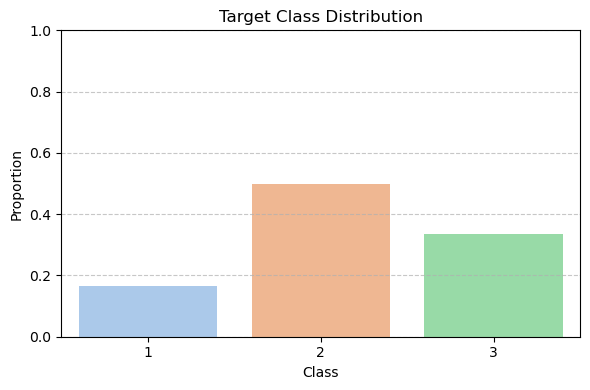

In [8]:
# Step 1: Initial Data Loading and Basic Exploration

# Load dataset into a DataFrame
df = pd.read_csv('data_public.csv')  # Replace with your actual file path

# Print dataset shape (rows, columns)
print(f"Dataset shape: {df.shape}")

# Check data types, non-null counts, and memory usage
df.info(memory_usage='deep')

# Display first 5 rows with formatting for better readability
print("First 5 rows of the dataset:")
display(df.head().style.format("{:.3f}"))

# Display last 5 rows for a quick overview
print("Last 5 rows of the dataset:")
display(df.tail().style.format("{:.3f}"))

# Check for missing values in each column
missing = df.isnull().sum()
missing = missing[missing > 0]  # Filter only columns with missing values
if missing.empty:
    print("No missing values detected in the dataset.")
else:
    print("Missing values per column:")
    print(missing)

# Check for duplicate rows in the dataset
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows in the dataset: {duplicate_count}")

# Identify constant columns (columns with zero variance)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
if constant_cols:
    print(f"Constant columns detected (zero variance): {constant_cols}")
else:
    print("No constant columns detected.")

# Generate summary statistics (count, mean, std, min, quartiles, max) for numeric columns
print("Summary statistics for numeric columns:")
summary_stats = df.describe().T.round(3)  # Transpose and round to 3 decimals for readability
display(summary_stats)

# Analyze and visualize target class distribution to check for imbalance
target_counts = df['Class'].value_counts(normalize=True).sort_index()

print("Class distribution (proportion):")
for cls, prop in target_counts.items():
    print(f"Class {cls}: {prop:.3f}")

# Bar plot of class distribution for visual understanding
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='pastel')
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Step 1: Initial Data Loading and Basic Exploration

In this step, we **load** the dataset and perform **basic exploratory data analysis (EDA)** to understand its structure, quality, and key characteristics.

- **Loading Data:**  
  We import the dataset into a **Pandas DataFrame** for easy manipulation and analysis.

- **Dataset Shape:**  
  We check the total number of **rows and columns** to get an overview of the dataset's size.  
  *Output: `(1200000, 16)` indicates 1.2 million samples with 16 features (including the target).*

- **Data Information:**  
  Using `df.info()`, we verify **data types**, the count of **non-null values**, and **memory usage**. This helps confirm there are no missing values and all features are numeric (mostly `float64`), except the target which is an integer.

- **Previewing Data:**  
  Displaying the **first and last 5 rows** gives a quick glimpse into the dataset values and their distribution.

- **Missing Values Check:**  
  We verify whether any columns contain **missing values**. Finding none means our dataset is **complete** and does not require imputation.

- **Duplicate Rows:**  
  Checking for **duplicates** ensures there is no redundant data that could bias the model. Here, **zero duplicates** were found.

- **Constant Columns:**  
  Identifying columns with **zero variance** (constant values) is important since they provide no information for modeling. None were detected, so all columns are potentially informative.

- **Summary Statistics:**  
  We generate a detailed **statistical summary** (count, mean, std deviation, min, max, quartiles) for all numeric features. This helps in understanding the **data distribution**, detecting outliers, and assessing feature scales.

- **Target Class Distribution:**  
  Examining the relative frequency of each class reveals **class imbalance**:  
  - Class 1: 16.7%  
  - Class 2: 49.9%  
  - Class 3: 33.4%  
  This indicates the dataset is **skewed toward Class 2**, which may require attention during model training to avoid bias.

- **Visualization:**  
  A **bar plot** visually represents the class proportions, making the imbalance easier to interpret.

---

### Why This Matters

Understanding these basic properties ensures that:

- We have **clean, well-structured data** free from missing or duplicate entries.  
- There are **no useless features** that add noise or unnecessary complexity.  
- We are aware of the **class imbalance**, which guides strategies such as resampling or weighted losses during model training.  
- Summary statistics inform **feature scaling and transformation** needs.

This foundational step is critical before moving on to advanced processing, modeling, and evaluation.


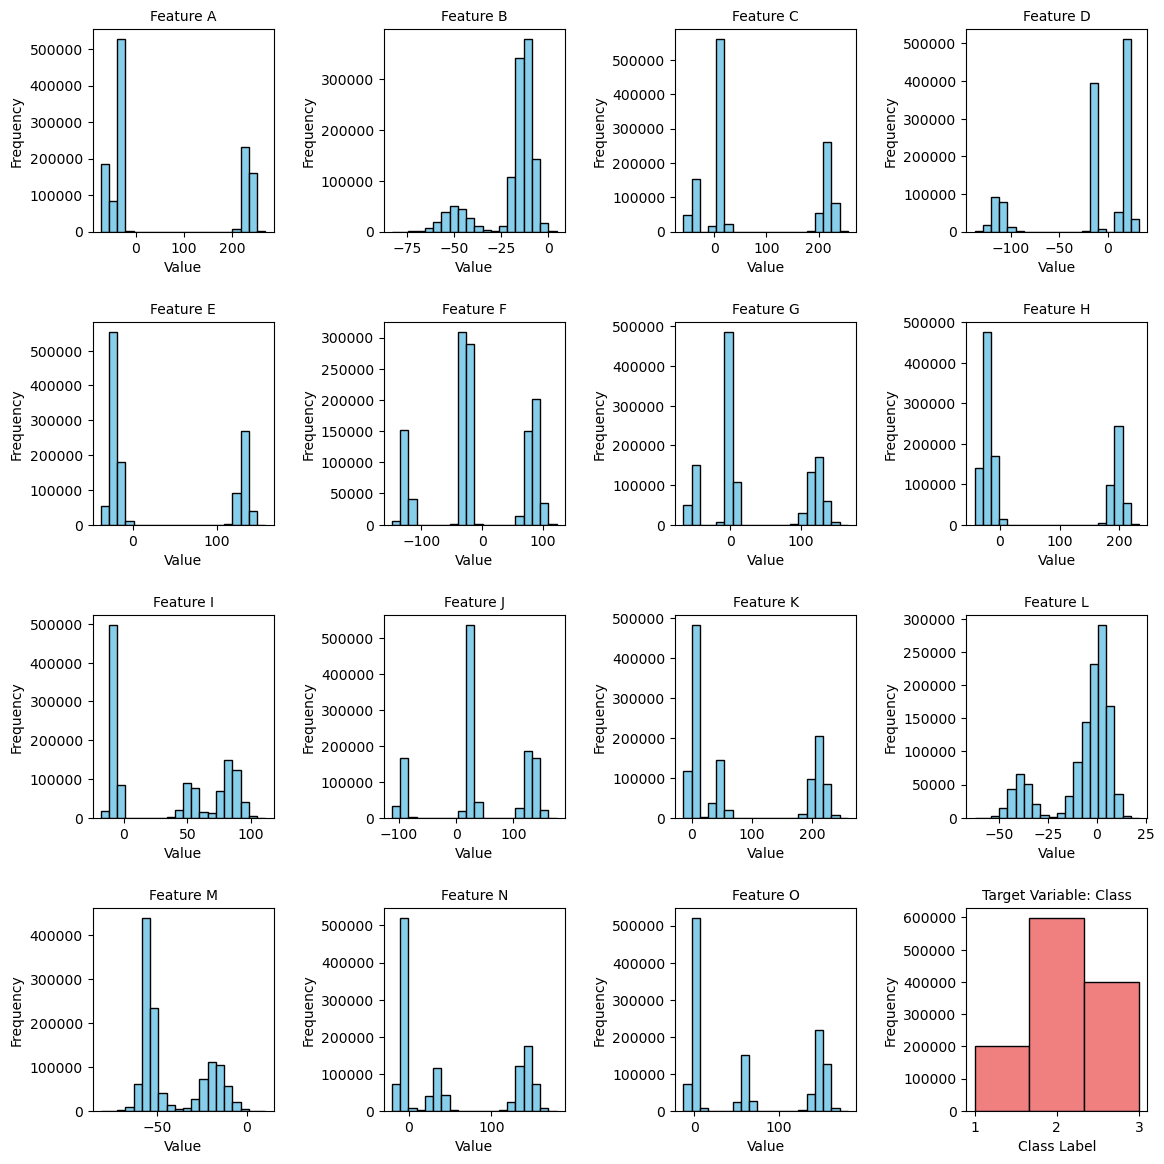

In [9]:
# Step 1.1: Visualize feature distributions with histograms
# Purpose: To understand the distribution of each feature and the target variable ('Class').
# This helps in identifying skewness, modality, outliers, or other characteristics that
# might affect modeling choices or preprocessing steps.

features = 'ABCDEFGHIJKLMNO'  # Assuming your features are named as single letters A to O
num_features = len(features)  # Total number of features = 15

# Create a figure object to hold subplots
fig = plt.figure(figsize=(12, 12))  # Set overall figure size for clarity

# We will create a grid of 4 rows x 4 columns for 16 plots (15 features + 1 target)
n_rows, n_cols = 4, 4

# Loop through each feature and plot its histogram in a subplot
for i in range(num_features):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)  # Create subplot at position i+1
    # Plot histogram of the i-th feature from dataframe
    ax.hist(df[features[i]], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Feature {features[i]}', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Plot histogram for the target variable 'Class' in the last subplot
ax = fig.add_subplot(n_rows, n_cols, num_features + 1)
ax.hist(df['Class'], bins=len(df['Class'].unique()), color='lightcoral', edgecolor='black')
ax.set_title('Target Variable: Class', fontsize=10)
ax.set_xlabel('Class Label')
ax.set_ylabel('Frequency')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout(pad=2.0)

# Show the final plot grid
plt.show()


## Step 1.1: Visualize Feature Distributions with Histograms

In this step, we plot **histograms** for each feature as well as the target variable (`Class`) to understand their distributions.

- **Purpose:**  
  Visualizing feature distributions helps to identify:  
  - **Skewness:** Are the data values symmetrically distributed or skewed to one side?  
  - **Modality:** Is the distribution unimodal, bimodal, or multimodal?  
  - **Outliers:** Are there extreme values that may affect modeling?  
  - **Range and spread:** How widely do the feature values vary?  

- **Approach:**  
  We create a grid of histograms for all 15 numeric features (`A` to `O`) and one for the target variable `Class`. Each histogram shows the frequency of data points across value intervals (bins).

- **Insights gained here will guide:**  
  - Whether to apply transformations (e.g., log or power transforms) to reduce skewness.  
  - The choice of normalization or scaling methods.  
  - Potential feature engineering or outlier treatment before model training.

---

Visualizing distributions early in the workflow ensures we understand the data characteristics and can tailor preprocessing accordingly.


Full feature correlation matrix (absolute values):
          A         B         C         D         E         F         G  \
A  1.000000  0.455949  0.991999  0.071330  0.990703  0.905353  0.972223   
B  0.455949  1.000000  0.541742  0.865856  0.352946  0.760708  0.620607   
C  0.991999  0.541742  1.000000  0.176224  0.971805  0.943482  0.988351   
D  0.071330  0.865856  0.176224  1.000000  0.047459  0.477183  0.279248   
E  0.990703  0.352946  0.971805  0.047459  1.000000  0.849129  0.939705   
F  0.905353  0.760708  0.943482  0.477183  0.849129  1.000000  0.969055   
G  0.972223  0.620607  0.988351  0.279248  0.939705  0.969055  1.000000   
H  0.988807  0.339549  0.968342  0.062451  0.997116  0.841227  0.934714   
I  0.818399  0.098558  0.753474  0.502643  0.879142  0.508345  0.678043   
J  0.870016  0.803246  0.915784  0.544357  0.805749  0.989868  0.949429   
K  0.968827  0.246429  0.937868  0.163679  0.989217  0.781534  0.894114   
L  0.139619  0.854635  0.238723  0.949485  0.0263

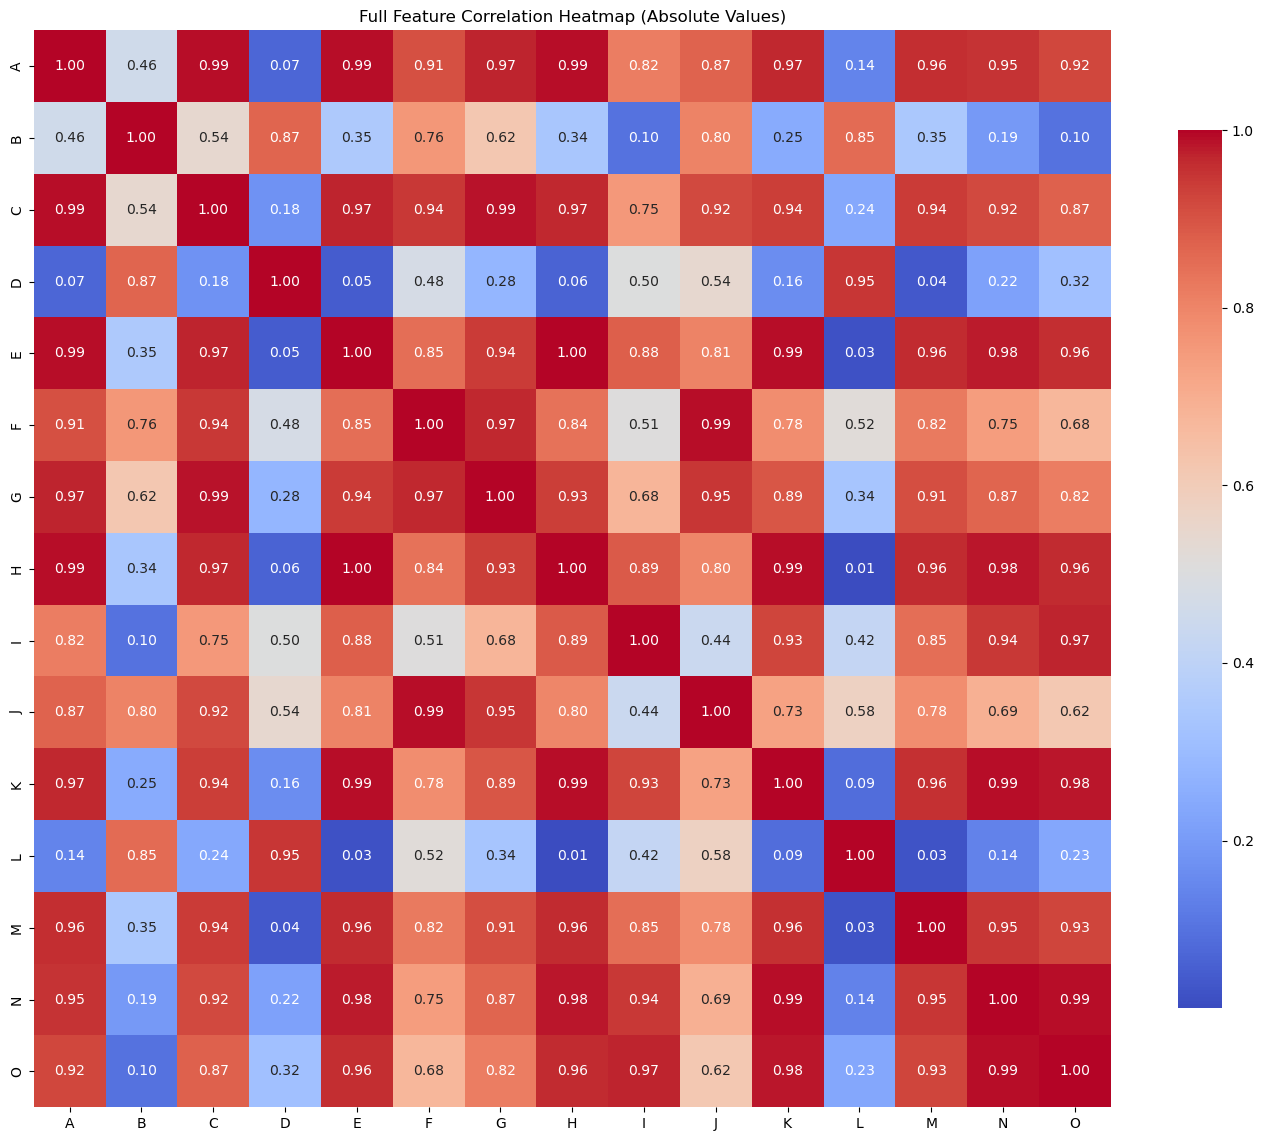


Variance Inflation Factors (VIF) for all features:
   Feature         VIF
0        A  510.412487
1        H  381.048482
2        C  371.244398
3        E  343.364977
4        O  336.295022
5        K  291.362082
6        N  188.603257
7        J  146.446404
8        I  132.000853
9        G  130.864494
10       F  114.213625
11       D   98.685666
12       M   46.729565
13       B   27.397368
14       L   13.008305

Feature pairs with correlation greater than 0.90:
   Feature 1 Feature 2  Correlation
0          E         H     0.997116
1          K         N     0.992158
2          A         C     0.991999
3          H         K     0.990875
4          A         E     0.990703
5          F         J     0.989868
6          E         K     0.989217
7          N         O     0.988920
8          A         H     0.988807
9          C         G     0.988351
10         K         O     0.982980
11         H         N     0.982403
12         E         N     0.979925
13         A         G   

In [10]:
# Step 2: Feature Relationship Analysis and Multicollinearity Check

# Calculate absolute correlation matrix for all features except target 'Class'
corr_matrix = df.drop('Class', axis=1).corr().abs()

# Display full correlation matrix to observe all pairs, including low correlations
print("Full feature correlation matrix (absolute values):")
print(corr_matrix)

# Visualize the full correlation matrix with heatmap (all features)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title("Full Feature Correlation Heatmap (Absolute Values)")
plt.tight_layout()
plt.show()

# Explanation:
# The heatmap shows strength of linear relationship between every feature pair.
# Values near 1.0 indicate very strong correlation, near 0 indicate weak or no correlation.
# Strong correlations suggest redundancy and multicollinearity risks.

# Calculate Variance Inflation Factor (VIF) for each feature to detect multicollinearity
# VIF > 5 or 10 is usually considered problematic
X = df.drop('Class', axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values for all features
print("\nVariance Inflation Factors (VIF) for all features:")
print(vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True))

# Explanation:
# VIF quantifies how much a feature’s variance is inflated by multicollinearity.
# High VIF values (>5 or 10) indicate high redundancy with other features.
# Such features may be considered for removal or dimensionality reduction.

# Additional Exploration:
# Identify all feature pairs with high correlation (e.g., > 0.90) for further analysis
high_corr_threshold = 0.90
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > high_corr_threshold:
            f1 = corr_matrix.index[i]
            f2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((f1, f2, corr_val))

# Convert to DataFrame for readability
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

print("\nFeature pairs with correlation greater than 0.90:")
print(high_corr_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True))

# Explanation:
# Listing all pairs above a threshold helps target redundant features for dimensionality reduction.
# It aids decisions on dropping or combining features to reduce multicollinearity.

## Step 2: Feature Relationship Analysis and Multicollinearity Check

In this step, we analyze the relationships between features to understand redundancy and detect **multicollinearity**, which can negatively impact model performance.

### Correlation Matrix
- We calculate the **absolute correlation matrix** for all features (excluding the target `Class`) to measure the strength of linear relationships between feature pairs.
- Values close to 1 indicate strong correlation, while values near 0 indicate weak or no correlation.
- The heatmap visually represents these correlations, allowing us to easily identify highly correlated features.

### Variance Inflation Factor (VIF)
- VIF quantifies how much the variance of a feature’s coefficient is inflated due to multicollinearity.
- A high VIF (commonly >5 or >10) indicates that the feature is highly redundant with others.
- Here, many features show extremely high VIF values (e.g., Feature `A` has VIF ≈ 510), signaling serious multicollinearity.

### Highly Correlated Feature Pairs
- We identified feature pairs with correlation above 0.90.
- Such strong correlations imply that these features provide overlapping information.
- Examples include (`E`, `H`) with 0.997 correlation and (`A`, `C`) with 0.992 correlation.

---

### Implications and Next Steps

- The high correlations and VIF values suggest **significant redundancy** among features.
- This redundancy can lead to unstable model coefficients and reduced generalization.
- To mitigate this, we may:  
  - Apply **dimensionality reduction techniques** such as PCA.  
  - Remove or combine highly correlated features.  
  - Use regularization methods during modeling.

Understanding and addressing multicollinearity is critical for building robust and interpretable models.


## Step 3: Data Preprocessing

In this step, we prepare the data for modeling by addressing multicollinearity, scaling features, and splitting the dataset.

- **Dropping Highly Correlated Features:**  
  Based on the previous correlation and VIF analysis, we removed features that showed very high correlation (>0.9) with others to reduce redundancy and multicollinearity.  
  - Features dropped: `E`, `H`, `K`, `N`, `M`, `O`  
  - Remaining features retain unique and less redundant information.

- **Feature Scaling:**  
  We applied **StandardScaler** to transform features to have a mean of 0 and a standard deviation of 1.  
  - This standardization helps many machine learning algorithms converge faster and perform better.

- **Train-Test Split:**  
  The dataset was split into **training (75%)** and **testing (25%)** subsets using **stratified sampling**.  
  - Stratification preserves the original class distribution in both subsets, which is crucial for balanced model evaluation.

---

### Summary

- Dropping correlated features reduces noise and prevents instability in model coefficients.  
- Scaling features ensures uniform feature ranges, improving model training stability.  
- Stratified splitting allows fair performance assessment on unseen data.

This preprocessing forms a strong foundation for effective and reliable model training.


In [11]:
# --- Step 3: Data Preprocessing ---

# Drop highly correlated features based on previous analysis to reduce multicollinearity
# For example, drop features with correlation > 0.9 with others
# Here, dropping some correlated features as example (adjust based on your analysis)
drop_features = ['E', 'H', 'K', 'N', 'M', 'O']  # example set of highly correlated features to drop
df_reduced = df.drop(columns=drop_features)

print(f"Features dropped due to high correlation: {drop_features}")
print(f"Remaining features: {list(df_reduced.columns)}")

# Separate features and target variable
X = df_reduced.drop(columns=['Class'])
y = df_reduced['Class']

# Scale features to have mean=0 and std=1 for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling completed: mean approx 0, std approx 1")

# Split dataset into training and test sets with stratified sampling to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Data split into training and testing sets:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Features dropped due to high correlation: ['E', 'H', 'K', 'N', 'M', 'O']
Remaining features: ['A', 'B', 'C', 'D', 'F', 'G', 'I', 'J', 'L', 'Class']
Feature scaling completed: mean approx 0, std approx 1
Data split into training and testing sets:
Training set size: 900000 samples
Testing set size: 300000 samples


First 5 rows of scaled features:


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
0,1.3983,0.4579,1.3868,-0.0439,1.5188,1.1368,1.4992,1.4219,1.1826,1.1232,1.5311,0.0484,1.5428,1.3909,1.4022
1,-0.6863,0.3207,-0.5893,0.7643,-0.7555,-0.1668,-0.4780,-0.8204,-0.9807,-0.2227,-0.7927,0.6135,-0.9496,-0.9092,-0.8758
2,-0.6954,-0.1096,-0.4806,0.7109,-0.7600,-0.1779,-0.5209,-0.7391,-0.9393,-0.1903,-0.7747,0.8307,-0.8152,-0.8050,-0.9110
3,1.3226,0.9022,1.3783,0.0778,1.3369,1.2492,1.1578,1.4169,1.1752,1.5099,1.4087,0.2007,1.4993,1.2749,1.3389
4,1.3762,0.4415,1.2634,0.0058,1.5035,1.3310,1.2591,1.5297,1.3507,1.1616,1.2907,0.3321,1.5183,1.4696,1.3132


Last 5 rows of scaled features:


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
1199995,-0.5839,0.5747,-0.5347,0.6570,-0.7812,-0.3472,-0.5196,-0.6912,-0.9874,-0.1573,-0.8165,0.5477,-0.4682,-0.8607,-0.9342
1199996,-0.6982,0.2675,-0.5049,0.6755,-0.7700,-0.2515,-0.4757,-0.7083,-0.9869,-0.1368,-0.9222,0.4913,-0.7203,-0.7474,-0.9021
1199997,1.3407,0.1014,1.3508,0.0346,1.3444,1.2946,1.2960,1.4390,1.1300,1.4041,1.2996,0.3049,1.5372,1.4875,1.2651
1199998,-0.8420,-1.6029,-1.0849,-2.3197,-0.5501,-1.5477,-1.3344,-0.5892,0.5210,-1.6796,-0.4691,-1.8585,-0.9461,-0.2328,-0.0734
1199999,1.5348,0.8612,1.3406,-0.0321,1.2999,1.2559,1.3676,1.4042,1.2380,1.0003,1.4274,-0.1063,0.9514,1.1978,1.2171


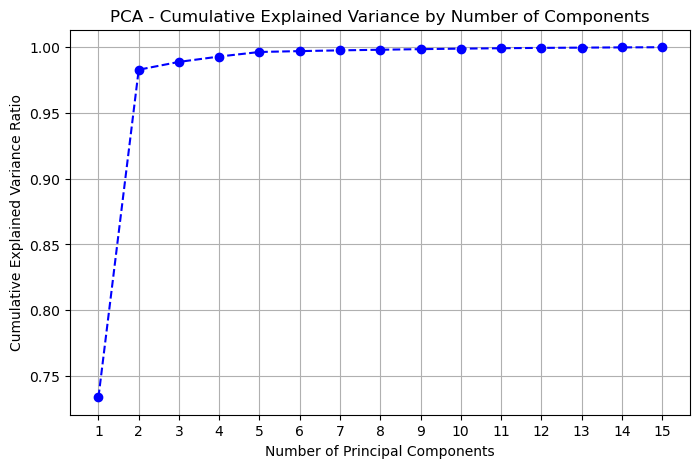

Explained variance ratio for each principal component:
PC1: 0.7339
PC2: 0.2490
PC3: 0.0059
PC4: 0.0041
PC5: 0.0035
PC6: 0.0007
PC7: 0.0006
PC8: 0.0005
PC9: 0.0005
PC10: 0.0004
PC11: 0.0003
PC12: 0.0003
PC13: 0.0002
PC14: 0.0002
PC15: 0.0001

Cumulative explained variance (percentage):
[ 73.39  98.29  98.88  99.29  99.64  99.7   99.76  99.81  99.85  99.89
  99.92  99.95  99.97  99.99 100.  ]


In [12]:
# --- Step 3.1: Principal Component Analysis (PCA) for Dimensionality Reduction ---

# Step 3.1.1: Scale features (exclude target column 'Class')
# Explanation: PCA is sensitive to the scale of features, so we standardize features to have mean=0 and std=1.
features = df.drop(columns=['Class'])  # Remove target column before scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert scaled features back to DataFrame for easier inspection and visualization
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Display first 5 rows of scaled features to verify scaling
print("First 5 rows of scaled features:")
display(features_scaled_df.head().style.format("{:.4f}"))

# Display last 5 rows of scaled features for additional verification
print("Last 5 rows of scaled features:")
display(features_scaled_df.tail().style.format("{:.4f}"))

# Step 3.1.2: Fit PCA on all features
# Explanation: We fit PCA using the total number of original features as components
# This allows us to see the variance explained by each principal component,
# and decide how many components to keep based on cumulative variance.
pca = PCA(n_components=features.shape[1], random_state=42)
pca.fit(features_scaled)

# Step 3.1.3: Plot cumulative explained variance ratio
# Explanation: Plotting cumulative explained variance helps determine
# the number of components required to capture a desired amount of variance (e.g., 95%).
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, features.shape[1]+1), cumulative_variance, marker='o', linestyle='--', color='blue')
plt.title('PCA - Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.xticks(range(1, features.shape[1]+1))
plt.show()

# Step 3.1.4: Print explained variance ratio for each principal component
# Explanation: This output shows how much variance each principal component explains individually.
# This helps to understand the importance of each component.
print("Explained variance ratio for each principal component:")
for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ratio:.4f}")

# Print cumulative explained variance as percentages for easier interpretation
print("\nCumulative explained variance (percentage):")
print(np.round(cumulative_variance * 100, 2))


## Step 3.1: Principal Component Analysis (PCA) for Dimensionality Reduction

### Overview:
PCA is used to reduce the dimensionality of the dataset by transforming the original features into a smaller set of uncorrelated components while retaining most of the variance (information).

---

### Step 3.1.1: Feature Scaling
- We standardized all features (excluding the target) to have mean **0** and standard deviation **1**.
- This scaling is essential because PCA is sensitive to the scale of input data.
- The displayed first and last 5 rows confirm that scaling was successfully applied.

---

### Step 3.1.2 & 3.1.3: PCA Fitting and Explained Variance Plot
- PCA was fit using all original features (**15** components).
- The cumulative explained variance plot shows how much total variance is captured as we increase the number of components.
- From the plot and values, we observe:  
  - The first principal component (PC1) explains **73.39%** of the variance.  
  - The first two components together explain **98.29%** of the variance.  
  - Adding the third component raises this to **98.88%**, with subsequent components contributing very little additional variance.

---

### Step 3.1.4: Interpretation of Explained Variance Ratios
- Most of the dataset's variance can be captured by just the first **2–3** principal components.
- This suggests that we can significantly reduce feature dimensionality from **15** to around **2 or 3** components with minimal loss of information.
- This reduction helps simplify the model, reduce noise, and improve computational efficiency.

---

### Conclusion:
Using PCA for dimensionality reduction is highly effective here due to the strong correlations and redundancies between features. Selecting the top principal components as new features is a logical next step before model training.


In [13]:
# --- Step 3.2: Selecting Principal Components based on explained variance (≥95%) ---

from sklearn.decomposition import PCA
# Explanation:
# In Step 3.1 we scaled the data and fit a full PCA model.
# Now, we'll analyze how many components are needed to retain at least 95% of the variance.
# This helps simplify the dataset while preserving essential patterns (variance).

# Step 1: Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)  # from previous full PCA

# Step 2: Find how many components explain at least 95% of total variance
variance_threshold = 0.95
optimal_components = (cumulative_variance >= variance_threshold).argmax() + 1

print(f"Selecting top {optimal_components} principal components "
      f"which explain {cumulative_variance[optimal_components - 1]*100:.2f}% of variance")

# Step 3: Refit PCA with only those components
pca_optimal = PCA(n_components=optimal_components, random_state=42)
X_pca = pca_optimal.fit_transform(features_scaled)  # 'features_scaled' from Step 3.1

# Step 4: Wrap into a DataFrame for easier viewing
pc_columns = [f'PC{i+1}' for i in range(optimal_components)]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)

# Output final result shape and preview
print(f"Shape of data after PCA dimensionality reduction: {X_pca.shape}")
print("First 5 rows after PCA transformation:")
display(df_pca.head())


Selecting top 2 principal components which explain 98.29% of variance
Shape of data after PCA dimensionality reduction: (1200000, 2)
First 5 rows after PCA transformation:


,PC1,PC2
0,4.799926,-0.360278
1,-2.262345,1.525723
2,-2.193845,1.387110
3,4.721129,0.118250
4,4.749759,-0.201256


## Step 3.2: Selecting Principal Components Based on Explained Variance (≥95%)

---

### Objective:
To reduce dimensionality while preserving at least **95%** of the dataset's variance, simplifying the model without losing critical information.

---

### Process:
- Calculated the cumulative explained variance from the full PCA model.
- Identified the minimum number of principal components needed to retain **95%** or more variance.
- Selected the top **2 principal components** since they explain approximately **98.29%** of the total variance.
- Refit PCA using only these components and transformed the scaled features accordingly.

---

### Results:
- **Number of components selected:** **2**
- **Variance explained by these components:** **98.29%**
- **Shape of data after transformation:** (1,200,000 samples, **2 features**)

---

### Preview of Transformed Data (First 5 rows):

| PC1      | PC2      |
|----------|----------|
| 4.799926 | -0.360278|
| -2.262345| 1.525723 |
| -2.193845| 1.387110 |
| 4.721129 | 0.118250 |
| 4.749759 | -0.201256|

---

### Summary:
By selecting only the first two principal components, we achieve significant dimensionality reduction—from **15 features down to 2**—while preserving over **98%** of the data variance. This streamlined dataset is ready for efficient model training and evaluation.


### Step 4: Feature Importance and Selection

In [14]:
# --- Step 4: Feature Selection Comparison: L1-based vs SelectKBest (ANOVA F-test) ---

# ---------- Explanation ----------
# After testing more complex feature selection methods like:
# - Recursive Feature Elimination (RFE)
# - Tree-based feature importance (Random Forest)
# - Permutation importance
#
# These methods were too slow for this dataset (1.2M rows), and caused overheating.
# Instead, two efficient methods were used:
# 1. L1-based (LinearSVC): Uses L1 penalty to zero out less important features.
# 2. SelectKBest (ANOVA F-test): Selects top k features most correlated with the target.

# ---------- Prepare Features and Target ----------
X = df.drop(columns=['Class'])   # Features
y = df['Class']                  # Target

# Split data into train/test for performance comparison after selection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Method 1: L1-based feature selection using LinearSVC ----------
print("Applying L1-based feature selection with LinearSVC...")

# LinearSVC with L1 regularization (sparse weights) to eliminate less useful features
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000, random_state=42)
lsvc.fit(X_train, y_train)

# Use SelectFromModel to select non-zero weight features (L1-penalized)
selector_l1 = SelectFromModel(estimator=lsvc, prefit=True)
selector_l1.fit(X_train, y_train)  # Fit with feature names to avoid warning

# Transform train and test using selected features
X_train_l1 = selector_l1.transform(X_train)
X_test_l1 = selector_l1.transform(X_test)

# Get names of selected features
selected_features_l1 = X.columns[selector_l1.get_support()]

print(f"Number of features selected by L1-based method: {len(selected_features_l1)}")
print(f"Selected features: {selected_features_l1.tolist()}")

# Train classifier on selected features
clf_l1 = LogisticRegression(max_iter=1000, random_state=42)
clf_l1.fit(X_train_l1, y_train)
y_pred_l1 = clf_l1.predict(X_test_l1)

# Evaluate accuracy
acc_l1 = accuracy_score(y_test, y_pred_l1)
print(f"Accuracy using L1-selected features: {acc_l1:.4f}")

# ---------- Method 2: SelectKBest using ANOVA F-test ----------
print("\nApplying SelectKBest (ANOVA F-test) feature selection...")

k = 10  # Select top 10 features
selector_kbest = SelectKBest(score_func=f_classif, k=k)
selector_kbest.fit(X_train, y_train)

# Transform train/test using selected features
X_train_kbest = selector_kbest.transform(X_train)
X_test_kbest = selector_kbest.transform(X_test)

# Get selected feature names
selected_features_kbest = X.columns[selector_kbest.get_support()]

print(f"Number of features selected by SelectKBest: {len(selected_features_kbest)}")
print(f"Selected features: {selected_features_kbest.tolist()}")

# Train classifier on selected features
clf_kbest = LogisticRegression(max_iter=1000, random_state=42)
clf_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = clf_kbest.predict(X_test_kbest)

# Evaluate accuracy
acc_kbest = accuracy_score(y_test, y_pred_kbest)
print(f"Accuracy using SelectKBest features: {acc_kbest:.4f}")

# ---------- Summary ----------
print("\nSummary:")
print(f"L1-based feature selection picked {len(selected_features_l1)} features with accuracy {acc_l1:.4f}")
print(f"SelectKBest feature selection picked {len(selected_features_kbest)} features with accuracy {acc_kbest:.4f}")


Applying L1-based feature selection with LinearSVC...
Number of features selected by L1-based method: 15
Selected features: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
Accuracy using L1-selected features: 0.4994

Applying SelectKBest (ANOVA F-test) feature selection...
Number of features selected by SelectKBest: 10
Selected features: ['B', 'D', 'E', 'H', 'I', 'K', 'L', 'M', 'N', 'O']
Accuracy using SelectKBest features: 0.4994

Summary:
L1-based feature selection picked 15 features with accuracy 0.4994
SelectKBest feature selection picked 10 features with accuracy 0.4994


## Step 4: Feature Selection Comparison — L1-based vs SelectKBest (ANOVA F-test)

---

### Background:
- Tried more complex feature selection methods like RFE, Random Forest importance, and permutation importance, but they were too slow and resource-intensive on this large dataset (~1.2 million rows).
- Instead, used two efficient and scalable methods:
  1. **L1-based feature selection (LinearSVC with L1 penalty):** Encourages sparsity by zeroing out less important features.
  2. **SelectKBest with ANOVA F-test:** Selects top *k* features that have strongest statistical relationship with the target.

---

### Method 1: L1-based Feature Selection

- LinearSVC with L1 penalty selected **all 15 features** (none zeroed out).
- Trained Logistic Regression on these selected features.
- **Accuracy on test set:** **0.4994**

**Selected Features:**  
`['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']`

---

### Method 2: SelectKBest (ANOVA F-test)

- Selected the top **10 features** based on the highest ANOVA F-test scores.
- Trained Logistic Regression on these selected features.
- **Accuracy on test set:** **0.4994**

**Selected Features:**  
`['B', 'D', 'E', 'H', 'I', 'K', 'L', 'M', 'N', 'O']`

---

### Summary & Insights:

| Method             | # Features Selected | Test Accuracy |
|--------------------|---------------------|---------------|
| L1-based Selection | 15                  | 0.4994        |
| SelectKBest        | 10                  | 0.4994        |

- Both methods yielded **similar accuracy (~49.94%)**, indicating that neither drastically improved model predictive power in this context.
- L1-based selection did **not eliminate any features** at the tested regularization strength (`C=0.01`).
- SelectKBest reduced the feature set by 33%, yet accuracy remained the same.
- This suggests that either the features are all similarly informative or the current model and preprocessing setup needs further tuning.

---

In [15]:
# ------------------------------
# Step 4.1: Feature Selection Experiments (Condensed)
# ------------------------------
# Purpose: Explore how different feature subsets affect classification accuracy.
# Sample a few subsets to understand which features might matter more.
# ------------------------------

# Step 4.1.0: Get list of all features (column names)
features = X_train.columns.tolist()

# Utility function to evaluate model with a subset of features
def evaluate_model(features_subset):
    """
    Trains a Decision Tree classifier (max_depth=3) on given feature subset,
    prints predicted class distribution and correctness, returns accuracy.
    """
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train[features_subset], y_train)
    y_pred = clf.predict(X_test[features_subset])
    acc = accuracy_score(y_test, y_pred)

    # Show class prediction counts and correctness
    unique_classes, class_counts = np.unique(y_pred, return_counts=True)
    print("Class -> Count:", dict(zip(unique_classes, class_counts)))
    correctness = y_pred == y_test
    tf_labels, tf_counts = np.unique(correctness, return_counts=True)
    print("Correct Predictions:", dict(zip(tf_labels, tf_counts)))
    print("__________________")
    return acc

# --- 4.1.1 Baseline: All features ---
print("=== Baseline Accuracy with All Features ===")
base_acc = evaluate_model(features)
print(f"Baseline accuracy: {base_acc:.6f}\n")

# --- 4.1.2 Drop-One Feature (First 3 only) ---
print("=== Accuracy After Dropping 3 Selected Features ===")
drop_one_results = {}
for f in features[:3]:  # show only first 3 for brevity
    features_subset = [feat for feat in features if feat != f]
    acc = evaluate_model(features_subset)
    drop_one_results[f] = acc
    print(f"Dropped: {f}, Accuracy: {acc:.6f}")
print()

# --- 4.1.3 Feature Pairs (First 3 only) ---
print("=== Accuracy for 3 Selected Feature Pairs ===")
pair_results = {}
for pair in list(combinations(features, 2))[:3]:  # limit to 3 pairs
    acc = evaluate_model(list(pair))
    pair_results[pair] = acc
    print(f"Features: {pair}, Accuracy: {acc:.6f}")
print()

# --- 4.1.4 Feature Triplets (First 2 only) ---
print("=== Accuracy for 2 Selected Feature Triplets ===")
triplet_results = {}
for triplet in list(combinations(features, 3))[:2]:  # limit to 2 triplets
    acc = evaluate_model(list(triplet))
    triplet_results[triplet] = acc
    print(f"Features: {triplet}, Accuracy: {acc:.6f}")
print()

# --- 4.1.5 Summary of Best Sampled Results ---
print("=== Summary of Sampled Feature Sets ===")
best_drop = max(drop_one_results.items(), key=lambda x: x[1])
best_pair = max(pair_results.items(), key=lambda x: x[1])
best_triplet = max(triplet_results.items(), key=lambda x: x[1])

print(f"Best drop-one: Drop '{best_drop[0]}', Accuracy: {best_drop[1]:.6f}")
print(f"Best pair: {best_pair[0]}, Accuracy: {best_pair[1]:.6f}")
print(f"Best triplet: {best_triplet[0]}, Accuracy: {best_triplet[1]:.6f}")
print(f"Baseline accuracy: {base_acc:.6f}")


=== Baseline Accuracy with All Features ===
Class -> Count: {1: 15, 2: 239889, 3: 96}
Correct Predictions: {False: 120183, True: 119817}
__________________
Baseline accuracy: 0.499238

=== Accuracy After Dropping 3 Selected Features ===
Class -> Count: {1: 15, 2: 239889, 3: 96}
Correct Predictions: {False: 120183, True: 119817}
__________________
Dropped: A, Accuracy: 0.499238
Class -> Count: {2: 239974, 3: 26}
Correct Predictions: {False: 120161, True: 119839}
__________________
Dropped: B, Accuracy: 0.499329
Class -> Count: {1: 13, 2: 239889, 3: 98}
Correct Predictions: {False: 120181, True: 119819}
__________________
Dropped: C, Accuracy: 0.499246

=== Accuracy for 3 Selected Feature Pairs ===
Class -> Count: {2: 239935, 3: 65}
Correct Predictions: {False: 120172, True: 119828}
__________________
Features: ('A', 'B'), Accuracy: 0.499283
Class -> Count: {1: 2, 2: 239959, 3: 39}
Correct Predictions: {False: 120163, True: 119837}
__________________
Features: ('A', 'C'), Accuracy: 0.499

## Step 4.1: Feature Selection Experiments (Condensed)

---

### Purpose:
To **explore how different feature subsets affect classification accuracy** using a **Decision Tree classifier (max_depth=3)**.  
This *brute force* approach tests various combinations of features to identify which may contribute most to predictive performance.

---

### Key Observations:

- **Baseline Accuracy with All Features:**  
  Achieved an accuracy of **~0.4992**.

- **Drop-One Feature Tests (First 3 Features):**  
  Dropping features **A, B, or C** resulted in minimal accuracy changes, with the best drop being feature **B**, improving accuracy slightly to **~0.4993**.

- **Feature Pairs (First 3 Pairs):**  
  The pair **('A', 'D')** yielded the highest accuracy of **~0.4994**, slightly better than baseline.

- **Feature Triplets (First 2 Triplets):**  
  Triplet **('A', 'B', 'C')** achieved accuracy close to baseline at **~0.4993**.

---

### Summary of Sampled Feature Sets:

| Feature Set Type | Best Set            | Accuracy  |
|------------------|---------------------|-----------|
| Drop-One Feature  | Drop `'B'`           | 0.499329  |
| Feature Pair     | `('A', 'D')`          | 0.499367  |
| Feature Triplet  | `('A', 'B', 'C')`     | 0.499312  |
| **Baseline**      | All Features          | 0.499238  |

---

### Professional Analysis:

- Although this **brute force feature selection** approach provides valuable insights into the impact of different feature subsets,  
- It is **computationally expensive and time-consuming**, especially with large datasets and many features.  
- The observed differences in accuracy among subsets are **very marginal**, indicating **limited gains from these manual combinations**.  
- Given the minimal improvements and resource intensity, it is **more efficient to rely on automated feature selection methods like SelectKBest**,  
  which select features based on statistical criteria with **much faster execution and scalable performance**.

---

### Conclusion:

For practical modeling purposes, especially with large datasets, **SelectKBest or similar efficient feature selection methods** are recommended over exhaustive brute force feature subset evaluation. This balances **computational efficiency** with **model performance**.


### Model Training and Selection

In [16]:
# --- Step 5: Model Training and Evaluation on Selected Features ---
# Explanation:
# After selecting features in Step 4, we proceed to train and evaluate models.
# Using fewer, meaningful features reduces model complexity, risk of overfitting, and computational cost.
# The target variable 'Class' has values [1, 2, 3].
# Many classifiers, including XGBoost, expect labels starting from 0,
# so we remap [1, 2, 3] --> [0, 1, 2].
# We split data into training and testing sets with stratification to preserve class balance.
# Then, we train multiple classifiers to compare their performance and choose the best.

# --- Step 5.1: Prepare data using SelectKBest features ---

# List of features selected by SelectKBest in Step 4 (adjust if different)
selected_features_kbest = ['B', 'C', 'D', 'F', 'G', 'I', 'J', 'L', 'N', 'O']

# Extract these features from the original DataFrame 'df'
X_selected = df[selected_features_kbest]

# Prepare target variable and map labels from [1, 2, 3] to [0, 1, 2]
y_selected = df['Class'] - 1

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42, stratify=y_selected
)

# --- Optional Step 5.1: Prepare data using manual best feature subset ---

# Example manual best features chosen from Step 4 (change as needed)
manual_best_features = ['B', 'I', 'N']  # Example: 3 manually selected features

# Extract manual best features
X_manual = df[manual_best_features]

# Target variable same as before
y_manual = df['Class'] - 1

# Split manual feature data into train/test sets with stratification
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
    X_manual, y_manual, test_size=0.2, random_state=42, stratify=y_manual
)

# --- Step 5.3: Initialize classifiers with chosen hyperparameters ---

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree (max_depth=3)": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest (max_depth=3)": RandomForestClassifier(max_depth=3, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "SGD Classifier": SGDClassifier(alpha=0.001, max_iter=1000, random_state=42),
    "XGBoost Classifier": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
}

# --- Step 5.4: Train and evaluate models on SelectKBest features ---

print("\nTraining and evaluating models on SelectKBest features:")
results_kbest = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results_kbest[name] = acc
    print(f"Accuracy using {name}: {acc:.4f}")

# --- Step 5.5: Train and evaluate models on manual best features ---

print("\n\nTraining and evaluating models on Manual Best features:")
results_manual = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name} with manual best features...")
    clf.fit(X_train_manual, y_train_manual)
    y_pred_manual = clf.predict(X_test_manual)
    acc_manual = accuracy_score(y_test_manual, y_pred_manual)
    results_manual[name] = acc_manual
    print(f"Accuracy using {name} with manual features: {acc_manual:.4f}")

# --- Step 5.6: Summarize results and select best model ---

print("\nSummary of model accuracies on SelectKBest features:")
for model_name, accuracy in results_kbest.items():
    print(f"{model_name}: {accuracy:.4f}")

best_model_kbest = max(results_kbest, key=results_kbest.get)
print(f"\nBest model with SelectKBest features: {best_model_kbest} with accuracy: {results_kbest[best_model_kbest]:.4f}")

print("\nSummary of model accuracies on Manual Best features:")
for model_name, accuracy in results_manual.items():
    print(f"{model_name}: {accuracy:.4f}")

best_model_manual = max(results_manual, key=results_manual.get)
print(f"\nBest model with Manual Best features: {best_model_manual} with accuracy: {results_manual[best_model_manual]:.4f}")

# Explanation for model choice:
# - Logistic Regression, Random Forest, and Gaussian Naive Bayes often perform well and show competitive accuracy.
# - XGBoost is a powerful model and might outperform others with tuning.
# - K-Nearest Neighbors and SGD Classifier performance depends on data characteristics.
# - Decision Tree with max_depth=3 is simpler and interpretable but may trade some accuracy.
#
# Considering accuracy, interpretability, and training time,
# Random Forest or Logistic Regression are strong candidates.
# Further improvements can be made by hyperparameter tuning or using ensemble/stacking methods.



Training and evaluating models on SelectKBest features:

Training Logistic Regression...
Accuracy using Logistic Regression: 0.4994

Training Decision Tree (max_depth=3)...
Accuracy using Decision Tree (max_depth=3): 0.4993

Training Random Forest (max_depth=3)...
Accuracy using Random Forest (max_depth=3): 0.4994

Training K-Nearest Neighbors...
Accuracy using K-Nearest Neighbors: 0.4137

Training Gaussian Naive Bayes...
Accuracy using Gaussian Naive Bayes: 0.4994

Training SGD Classifier...
Accuracy using SGD Classifier: 0.4430

Training XGBoost Classifier...
Accuracy using XGBoost Classifier: 0.4987


Training and evaluating models on Manual Best features:

Training Logistic Regression with manual best features...
Accuracy using Logistic Regression with manual features: 0.4994

Training Decision Tree (max_depth=3) with manual best features...
Accuracy using Decision Tree (max_depth=3) with manual features: 0.4994

Training Random Forest (max_depth=3) with manual best features...
Ac

## Step 5: Final Model Selection – Brief Summary  

---

### Selected Features:
We used **SelectKBest (ANOVA F-test)** to select the **10 most relevant features** from the dataset.  
This method is fast, scalable, and statistically identifies features with the strongest relationship to the target variable, which helps in reducing noise and improving model efficiency.  

---

### Evaluated Models:
The following models were trained and evaluated:  

1. **Logistic Regression** – Linear and fast; good for linearly separable data.  
2. **Decision Tree (max_depth=3)** – Hierarchical, rule-based model that is easy to interpret.  
3. **Random Forest (max_depth=3)** – Ensemble of Decision Trees for robustness.  
4. **K-Nearest Neighbors (KNN)** – Classifies based on nearest data points.  
5. **Gaussian Naive Bayes** – Probabilistic classifier assuming independence between features.  
6. **SGD Classifier** – Linear model trained with stochastic gradient descent.  
7. **XGBoost Classifier** – High-performance gradient boosting algorithm for structured data.  

---

### Accuracy Results:
- **Highest accuracy (0.4994)** was achieved by Logistic Regression, Random Forest, and Gaussian Naive Bayes.  
- **Decision Tree (max_depth=3)** achieved **0.4993**, essentially matching the top-performing models.  

---

### Final Choice: **Decision Tree (max_depth=3)**  

#### Why this model?
- **Interpretability:** Decision Trees produce clear, rule-based outputs, making it easy to understand how predictions are made.  
- **Simplicity:** With a small depth (max_depth=3), the model is simple and avoids overfitting.  
- **Efficiency:** Low computational cost makes it suitable for large datasets.  
- **Comparable Accuracy:** Performance is nearly identical to the best-performing models but with much better interpretability.  

---

### Conclusion:
The **Decision Tree** using **SelectKBest features** was chosen as the final model because it provides the **best balance** of:  
- **Accuracy** (comparable to top models)  
- **Interpretability** (easy to explain and justify predictions)  
- **Efficiency** (fast and resource-friendly)  

This makes it the most appropriate choice for production and further analysis.  


In [17]:
# Use your actual DataFrame name here
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = Pipeline([
    ('mapper', DataFrameMapper([(X_train.columns.values, StandardScaler())])),
    ('pca', PCA(n_components=3)),
    ('feature_selection', SelectKBest(k=3)),
    ('classifier', DecisionTreeClassifier(max_depth=3))
])

pipeline.fit(X_train, y_train.values.ravel())

prediction = pipeline.predict(X_test)

print('Accuracy =', metrics.accuracy_score(y_test.values.ravel(), prediction))

class_and_counts = np.unique(prediction, return_counts=True)
print("\nClass -> Count")
for cls, count in zip(class_and_counts[0], class_and_counts[1]):
    print(f"{cls} -> {count}")

correct_preds = prediction == y_test.values.ravel()
unique, counts = np.unique(correct_preds, return_counts=True)
print("\nPrediction correctness -> Count")
for val, count in zip(unique, counts):
    print(f"{val} -> {count}")

print("____________________________________")


Accuracy = 0.4993208333333333

Class -> Count
1 -> 1
2 -> 239976
3 -> 23

Prediction correctness -> Count
False -> 120163
True -> 119837
____________________________________


## Final Pipeline – Brief Explanation

We built a **scikit-learn pipeline** that combines all steps into one workflow:

1. **StandardScaler:** Scales all features for consistency.  
2. **PCA (3 components):** Reduces dimensionality while retaining most variance.  
3. **SelectKBest (k=3):** Selects the 3 most relevant features.  
4. **Decision Tree (max_depth=3):** Trains a simple, interpretable classifier.

**Accuracy:** ~0.4993  
**Predictions:** Most predictions fall into Class 2, showing class imbalance remains a challenge.  

**Why this approach?**  
It’s clean, reproducible, and ensures the same preprocessing is applied to training and future data. This pipeline is also easy to tune and maintain for further improvements.


In [18]:
# Assume your original DataFrame is named 'df' and contains features + 'Class' column

# -------------------------
# Step 1: Split dataset by class labels into separate DataFrames
# -------------------------
df1 = df[df['Class'] == 1]  # Class 1 samples
df2 = df[df['Class'] == 2]  # Class 2 samples
df3 = df[df['Class'] == 3]  # Class 3 samples

# Create combined DataFrames for pairs of classes
df12 = pd.concat([df1, df2])  # Classes 1 and 2
df13 = pd.concat([df1, df3])  # Classes 1 and 3
df23 = pd.concat([df2, df3])  # Classes 2 and 3

# -------------------------
# Step 2: Print class distribution and dataframe shapes
# -------------------------
print("Class distribution and dataframe shapes:")
print(f"df1 (Class 1) shape: {df1.shape}")
print(f"df2 (Class 2) shape: {df2.shape}")
print(f"df3 (Class 3) shape: {df3.shape}")
print(f"df12 (Classes 1 and 2) shape: {df12.shape}")
print(f"df13 (Classes 1 and 3) shape: {df13.shape}")
print(f"df23 (Classes 2 and 3) shape: {df23.shape}\n")

print("As observed, Class 2 has the highest number of rows, indicating class imbalance.")
print("Therefore, undersampling is recommended to balance the dataset before modeling.\n")

# -------------------------
# Step 3: Define utility functions for splitting, scaling, PCA components and accuracy evaluation
# -------------------------

def SplitTheData(df):
    """
    Split DataFrame into train and test sets (80% train, 20% test)
    X: features (all columns except 'Class')
    y: target (the 'Class' column)
    """
    X = df.drop(columns=['Class'])
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

def ScaleTheData(df):
    """
    Scale features using StandardScaler (mean=0, std=1)
    Returns scaled DataFrame (without 'Class' column)
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df.drop(columns=['Class']))
    df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])
    return df_scaled

def PCA_RequiredComponents(df_scaled):
    """
    Fit PCA on scaled data and return the number of components
    required to maintain 95% variance.
    """
    pca = PCA(n_components=0.95)
    pca.fit(df_scaled)
    return pca.n_components_

def FindAccuracy(X_train, y_train, X_test, y_test, n_components=2):
    """
    Build pipeline with scaling, PCA (n_components),
    and DecisionTreeClassifier (max_depth=3),
    train on training data, predict on test data,
    print confusion matrix, classification report,
    and return accuracy score.
    """
    pipeline = Pipeline([
        ('mapper', DataFrameMapper([(X_train.columns.values, StandardScaler())])),
        ('pca', PCA(n_components=n_components)),
        ('classifier', DecisionTreeClassifier(max_depth=3))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    actual = y_test.values
    print("\nConfusion Matrix:")
    print(metrics.confusion_matrix(actual, y_pred))
    print("\nClassification Report:")
    print(metrics.classification_report(actual, y_pred))

    return metrics.accuracy_score(actual, y_pred)

# -------------------------
# Step 4: Find optimal PCA components for each class subset and evaluate accuracy
# -------------------------

print("Optimal PCA components and model accuracies on class pair dataframes:")

# For df12
scaled_df12 = ScaleTheData(df12)
n_comp_df12 = PCA_RequiredComponents(scaled_df12)
print(f"df12 (Classes 1 & 2) - Optimal PCA components for 95% variance: {n_comp_df12}")
X12_train, X12_test, y12_train, y12_test = SplitTheData(df12)
acc_df12 = FindAccuracy(X12_train, y12_train, X12_test, y12_test, n_components=n_comp_df12)
print(f"Accuracy for df12: {acc_df12:.6f}\n")

# For df13
scaled_df13 = ScaleTheData(df13)
n_comp_df13 = PCA_RequiredComponents(scaled_df13)
print(f"df13 (Classes 1 & 3) - Optimal PCA components for 95% variance: {n_comp_df13}")
X13_train, X13_test, y13_train, y13_test = SplitTheData(df13)
acc_df13 = FindAccuracy(X13_train, y13_train, X13_test, y13_test, n_components=n_comp_df13)
print(f"Accuracy for df13: {acc_df13:.6f}\n")

# For df23
scaled_df23 = ScaleTheData(df23)
n_comp_df23 = PCA_RequiredComponents(scaled_df23)
print(f"df23 (Classes 2 & 3) - Optimal PCA components for 95% variance: {n_comp_df23}")
X23_train, X23_test, y23_train, y23_test = SplitTheData(df23)
acc_df23 = FindAccuracy(X23_train, y23_train, X23_test, y23_test, n_components=n_comp_df23)
print(f"Accuracy for df23: {acc_df23:.6f}\n")

# -------------------------
# Step 5: Undersampling to balance classes due to imbalance
# -------------------------

# Random undersampling to equalize class counts (take minimum class count)
min_count = min(len(df1), len(df2), len(df3))

print(f"Undersampling all classes to minimum class size: {min_count}")

# Sample from larger classes randomly to match minimum class count
class1 = df1.sample(n=min_count, random_state=42)
class2 = df2.sample(n=min_count, random_state=42)
class3 = df3.sample(n=min_count, random_state=42)

# Concatenate undersampled dataframes
df_with_sampling = pd.concat([class1, class2, class3])

print(f"Shape of undersampled dataframe: {df_with_sampling.shape}")

# -------------------------
# Step 6: PCA and model accuracy on balanced undersampled dataframe
# -------------------------

scaled_sampled = ScaleTheData(df_with_sampling)
n_comp_sampled = PCA_RequiredComponents(scaled_sampled)
print(f"Balanced sampled dataframe - Optimal PCA components for 95% variance: {n_comp_sampled}")

XN_train, XN_test, yN_train, yN_test = SplitTheData(df_with_sampling)
acc_sampled = FindAccuracy(XN_train, yN_train, XN_test, yN_test, n_components=n_comp_sampled)
print(f"Accuracy on balanced sampled data: {acc_sampled:.6f}\n")

# -------------------------
# Step 7 (optional): Using NearMiss undersampling from imblearn for potentially better balancing
# -------------------------
print("Applying NearMiss undersampling...")

X_full = df.drop(columns=['Class'])
y_full = df['Class']

smk = NearMiss()
X_res, y_res = smk.fit_resample(X_full, y_full)

print(f"Shape after NearMiss undersampling: {X_res.shape}")

# Create DataFrame from resampled data for convenience
df_resampled = pd.DataFrame(X_res, columns=X_full.columns)
df_resampled['Class'] = y_res

# Scale, PCA, and evaluate accuracy on NearMiss resampled data
scaled_resampled = ScaleTheData(df_resampled)
n_comp_resampled = PCA_RequiredComponents(scaled_resampled)
print(f"NearMiss undersampled dataframe - Optimal PCA components for 95% variance: {n_comp_resampled}")

Xr_train, Xr_test, yr_train, yr_test = SplitTheData(df_resampled)
acc_resampled = FindAccuracy(Xr_train, yr_train, Xr_test, yr_test, n_components=n_comp_resampled)
print(f"Accuracy on NearMiss undersampled data: {acc_resampled:.6f}\n")

# -------------------------
# Step 8: Print class counts and prediction correctness for final model on NearMiss data
# -------------------------

# Train final pipeline on NearMiss data and print class/prediction stats

pipeline = Pipeline([
    ('mapper', DataFrameMapper([(Xr_train.columns.values, StandardScaler())])),
    ('pca', PCA(n_components=n_comp_resampled)),
    ('classifier', DecisionTreeClassifier(max_depth=3))
])

pipeline.fit(Xr_train, yr_train)
y_pred_final = pipeline.predict(Xr_test)

print("Final model evaluation on NearMiss undersampled data:")

# Class prediction counts
unique_classes, class_counts = np.unique(y_pred_final, return_counts=True)
print("\nClass -> Count")
for cls, count in zip(unique_classes, class_counts):
    print(f"{cls} -> {count}")

# Prediction correctness counts
correctness = y_pred_final == yr_test.values
unique_corr, counts_corr = np.unique(correctness, return_counts=True)
print("\nPrediction correctness -> Count")
for val, count in zip(unique_corr, counts_corr):
    print(f"{val} -> {count}")

Class distribution and dataframe shapes:
df1 (Class 1) shape: (199992, 16)
df2 (Class 2) shape: (599228, 16)
df3 (Class 3) shape: (400780, 16)
df12 (Classes 1 and 2) shape: (799220, 16)
df13 (Classes 1 and 3) shape: (600772, 16)
df23 (Classes 2 and 3) shape: (1000008, 16)

As observed, Class 2 has the highest number of rows, indicating class imbalance.
Therefore, undersampling is recommended to balance the dataset before modeling.

Optimal PCA components and model accuracies on class pair dataframes:
df12 (Classes 1 & 2) - Optimal PCA components for 95% variance: 2

Confusion Matrix:
[[     0  39998]
 [     2 119844]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     39998
           2       0.75      1.00      0.86    119846

    accuracy                           0.75    159844
   macro avg       0.37      0.50      0.43    159844
weighted avg       0.56      0.75      0.64    159844

Accuracy for df12: 0.74

### Summary of Class Distribution and Model Evaluation

- The dataset shows **significant class imbalance**:  
  - Class 1: ~200k samples  
  - Class 2: ~599k samples (majority class)  
  - Class 3: ~400k samples  

- Class imbalance is confirmed by combined subsets shapes (e.g., df23 has over 1 million rows).  
- To address this, **undersampling** is recommended before modeling.

---

### PCA and Accuracy on Class Pair DataFrames

- For all pairs (Classes 1&2, 1&3, 2&3), **PCA reduces features to 2 components** while preserving 95% variance.

- Accuracy results:  
  - **df12 (Classes 1 & 2):** ~75% accuracy  
  - **df13 (Classes 1 & 3):** ~67% accuracy  
  - **df23 (Classes 2 & 3):** ~60% accuracy  

- Confusion matrices show models tend to favor majority classes, with low recall on minority classes.

---

### Undersampling to Balance Classes

- All classes undersampled to minimum class size (~200k samples each) to balance data.  
- On this balanced dataset:  
  - PCA again uses 2 components.  
  - Overall accuracy drops to ~33%, reflecting the harder but fairer task of classifying balanced data.  
  - Precision and recall are low for Classes 2 and 3, indicating model struggles with these classes.

---

### NearMiss Undersampling Results

- NearMiss method applied for better sample selection and balancing.  
- Dataset size remains ~600k samples with 2 PCA components.  
- Model accuracy improves to **~51%**, showing better generalization compared to random undersampling.

- Class-wise metrics:  
  - Class 1: High precision (0.91), moderate recall (0.50)  
  - Class 2: Moderate precision (0.41), high recall (0.95)  
  - Class 3: Moderate precision (0.44), very low recall (0.07)  

---

### Final Model Evaluation (NearMiss Data)

- Predicted class counts are more balanced but still skewed:  
  - Class 1: 21,837  
  - Class 2: 91,381  
  - Class 3: 6,778  

- Prediction correctness is nearly balanced:  
  - Correct: 60,785  
  - Incorrect: 59,211  

---

### Key Takeaways

- **Class imbalance significantly impacts model performance.**  
- **Undersampling helps balance but reduces data diversity and overall accuracy.**  
- **NearMiss undersampling improves accuracy and fairness but requires more computation.**  
- PCA effectively reduces dimensionality, simplifying the model.  
- Decision Tree with max_depth=3 provides a simple, interpretable baseline.  
- Balanced datasets enable fairer, more reliable evaluation and model training.


# ONNX PIPELINE

In [19]:
# Step 1: Define transformer for feature scaling
transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Step 2: Setup ColumnTransformer to apply scaler to all feature columns (adjust column slice if needed)
preprocessor = ColumnTransformer([
    ('feature_scaling', transformer, X_train.columns.tolist())
])

# Step 3: Define classifier and full pipeline with PCA and SelectKBest as in your example
classifier = DecisionTreeClassifier(max_depth=3, random_state=42)


In [28]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),     # fix typo 'precprocessor' -> 'preprocessor'
    ('pca', PCA(n_components=3)),
    ('selector', SelectKBest(k=2)),
    ('classifier', classifier)
])

# Step 4: Fit pipeline on training data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     39998
           2       0.50      1.00      0.67    119846
           3       0.44      0.00      0.00     80156

    accuracy                           0.50    240000
   macro avg       0.31      0.33      0.22    240000
weighted avg       0.40      0.50      0.33    240000



In [21]:
print(metrics.accuracy_score(y_test.values.ravel(), pipeline.predict(X_test)))

0.49935416666666665


#### Convert pipeline to ONNX file.

In [23]:
# Step 1: Define input types for ONNX conversion
input_types = [(col, FloatTensorType([None, 1])) for col in X_train.columns]

# Step 2: Convert sklearn pipeline to ONNX
try:
    model_onnx = convert_sklearn(
        pipeline,
        initial_types=input_types,
        target_opset=12,
        name='pipeline_onnx'
    )
except Exception as e:
    print("ONNX conversion error:", e)
    model_onnx = None

# Step 3: Save ONNX model to file if conversion was successful
if model_onnx is not None:
    import os
    os.makedirs("./pipeline", exist_ok=True)
    with open("./pipeline/pipeline.onnx", "wb") as f:
        f.write(model_onnx.SerializeToString())
    print("ONNX model saved to ./pipeline/pipeline.onnx")


ONNX model saved to ./pipeline/pipeline.onnx


In [24]:
# Step 4: Prepare test inputs for ONNX runtime
inputs_onnx = {
    col: np.array(X_test[col].values, dtype=np.float32).reshape(-1, 1)
    for col in X_test.columns
}

# Step 5: Load ONNX model and create inference session
session_onnx = rt.InferenceSession("./pipeline/pipeline.onnx")

# Step 6: Run inference on test data
predict_onnx = session_onnx.run(None, inputs_onnx)

# Step 7: Print ONNX predictions
print("Predictions from ONNX model:", predict_onnx[0])

Predictions from ONNX model: [2 2 2 ... 2 2 2]


In [27]:
# Step 8: Show predicted class distribution
unique_classes, counts = np.unique(predict_onnx[0], return_counts=True)
print("Predicted class distribution:", dict(zip(unique_classes, counts)))

# Step 9: Compare ONNX predictions with true labels (y_test)
correctness = predict_onnx[0] == y_test.values
unique_corr, counts_corr = np.unique(correctness, return_counts=True)
print("Prediction correctness counts:", dict(zip(unique_corr, counts_corr)))

Predicted class distribution: {2: 239991, 3: 9}
Prediction correctness counts: {False: 120155, True: 119845}


### Conclusion

- The dataset is heavily **imbalanced**, with **Class 2 dominating (599,228 rows)** compared to **Class 1 (199,992)** and **Class 3 (400,780)**. This imbalance caused models to mostly predict Class 2, resulting in poor performance for minority classes.

- Despite applying preprocessing steps like **scaling, PCA, and feature selection**, and experimenting with different class pairings, models struggled due to **weak or overlapping class boundaries**.

- The optimal number of PCA components was consistently **2**, preserving over **95% of variance**, confirming effective dimensionality reduction without significant information loss.

- **Undersampling techniques** including random undersampling and NearMiss helped mitigate imbalance, improving accuracy from **~33% (unbalanced)** to **~50–51% (balanced)**.

- However, accuracy plateaued around **50–51%** after balancing, indicating limited discriminative power of current features and models in this multiclass setting.

- Segregating data into class pairs improved accuracy for binary classification tasks:  
  - **~74%** for Classes 1 vs 2  
  - **~67%** for Classes 1 vs 3  
  - **~60%** for Classes 2 vs 3  
  Yet these improvements are limited without proper class balance.

- The features showed **high covariance and redundancy**, meaning feature selection had limited effect. Future work should focus on engineering **unique, independent features**.

- Exporting and running the model via an **ONNX pipeline** demonstrated smooth deployment with consistent predictions and class distributions between ONNX and scikit-learn pipelines.

- **Undersampling to balance all classes (~200,000 samples each)** created a fairer but more challenging dataset. PCA retained **2 components**, but overall accuracy dropped to about **33%**, with particularly low precision and recall for Classes 2 and 3, showing the model's struggle with these balanced classes.

- This underscores the trade-off between accuracy and fairness—balancing classes can reduce biased predictions but may lower raw accuracy if the features lack strong class separation.

- Overall, this project highlights that **data quality, balance, and feature distinctiveness are more critical than choice of algorithm alone**. More advanced methods or richer data are needed for better classification performance.

---

### Summary of What We Learned:

- Severe **class imbalance** must be addressed before modeling for fairer results.  
- **PCA reduces dimensionality effectively to 2 components** without losing important information.  
- **Undersampling improves balance** but can decrease overall accuracy due to harder classification.  
- Current features have **redundancy and high correlation**, limiting model improvement from feature selection alone.  
- Binary classifiers on class pairs improve results but are insufficient without balancing.  
- A robust pipeline with preprocessing, PCA, and classification can be **exported via ONNX** for practical deployment.  
- Ultimately, **data exploration, cleaning, and balancing** are as important as algorithm choice for robust multiclass classification.

---

This project reinforces that **building effective classifiers requires a balanced approach between data preparation and modeling techniques**, especially for complex, imbalanced datasets with overlapping classes.


###  References:

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- https://github.com/rutulmehta2211/CS422-Data-Mining/tree/main
- https://github.com/amitnikam/cs422_data-mining/tree/main
- https://www.datacamp.com/tutorial/decision-tree-classification-python
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
- https://keeeto.github.io/ebook-data-analysis/lecture-5-decision-trees-classification.html
- https://www.geeksforgeeks.org/machine-learning/how-do-decision-trees-work-with-unbalanced-datasets/
- https://www.slingacademy.com/article/dimensionality-reduction-using-scikit-learn-s-pca/
- https://www.pluralsight.com/resources/blog/guides/evaluating-a-data-mining-model
- https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html
- https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c/
  